# Vaccine Myths from Reddit Data


<!-- 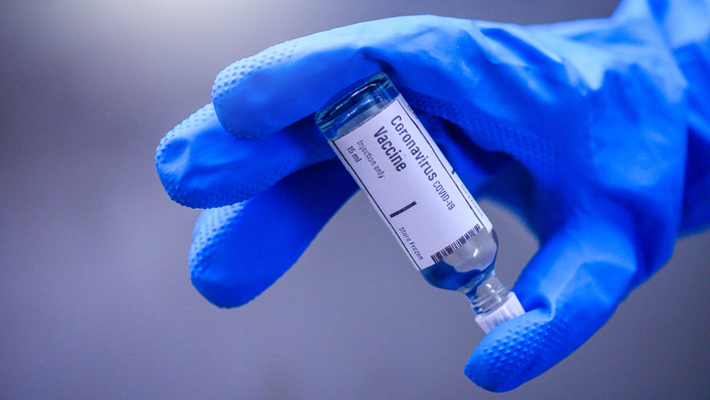 -->
<img align=left src = "https://fortisbangalore.com/frontend/blogimage/Covid-vaccination--1614614615.png" width="500">

**Top Four vaccine myths from my interpretation of results:**
<ol>
<li><b>Contents of vaccine (like mercury) and associated allergic reactions in body.</b></li>
<li><b>Disorders due to vaccine and improper findings due to less data.</b></li>
<li><b>Risk of autism in childern and Measles Antivaccine progaganda.</b></li>
<li><b>Vaccine shedding with vaccinated virus strain.</b></li>
</ol>

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
data = pd.read_csv('../input/reddit-vaccine-myths/reddit_vm.csv')
data.head()

In [ ]:
import missingno as msno
msno.bar(data, figsize=(12, 5))

**We have missing values in url and body columns. <br>Lets see how unique the titles are from title column.**

In [ ]:
data['title'].value_counts()

**Here we can see that there is only 450 unique titles out of which word comment occured 1030 times.<br> 
We can remove this word using stop words later.**

**Let us see the top five titles based on scores in score column**

In [ ]:
top_5_scores = list(data.nlargest(5,'score').index)
for index in top_5_scores:
    print(f'Score - {data["score"].iloc[index]}, Title - {data["title"].iloc[index]}')

**The top 5 scored titles are about vaccine side effects and how apprehensive some people are about taking the vaccine.**

**From url column we can see that there are images and news articles in them. <br>Let us try to extract text from them to get more data.<br>We will collect the urls with filetype image and html and their indices into a list.**

In [ ]:
# urls = list(data['url'].unique())
ocr_indexes = []
blog_text_indexes = []
ocr_urls = []
blog_text_urls = []

for i,ele in enumerate(data['url']):
    try:
        fil_type = ele.rsplit('.',1)[-1]
        if fil_type in ['jpg','png','jpeg']:
            ocr_indexes.append(i)
            ocr_urls.append(ele)
        elif fil_type == 'html':
            blog_text_indexes.append(i)
            blog_text_urls.append(ele)
    except:
        continue

In [ ]:
!pip install beautifulsoup4

In [ ]:
data['blog_text'] = ['']*data.shape[0]
data['ocr'] = ['']*data.shape[0]

**Scarpe html for text and add a new column blog_text with this data.**

In [ ]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re

for ind,url in zip(blog_text_indexes,blog_text_urls):
    try:
        req = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        page = urlopen(req)
        soup = BeautifulSoup(page)
        strings = soup.get_text().split(' ')

        clean_string = ''
        for ele in strings:
            if re.findall('^[a-zA-Z0-9_]+$',ele):
                clean_string = clean_string + ' ' + re.findall('^[a-zA-Z0-9_]+$',ele)[0]
            else:
                continue
        data['blog_text'].iloc[ind] = clean_string
    except:
        continue

**Similarly collect images and let us do ocr on these images for text.<br> I used <a href="https://github.com/PaddlePaddle/PaddleOCR">paddleocr</a> package for this.<br>The recognition result is not good for some images but majority of the extractions are good enough to be considered as text data.**

In [ ]:
# import the necessary packages
import numpy as np
import urllib
import cv2
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(i,url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    cv2.imwrite(f'./reddit_images/{i}.jpg',image)

In [ ]:
for i,url in enumerate(ocr_urls):
    try:
        url_to_image(i,url)
    except Exception as e:
        print(e)

In [ ]:
!pip install "paddleocr>=2.0.1"
!pip install paddlepaddle

**Run ocr recognition on these images and add a new column 'ocr' into dataframe** 

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
ocr = PaddleOCR(lang='en') # need to run only once to download and load model into memory
# images = sorted(glob.glob('/home/vineeth/reddit_images/*.jpg'),key=os.path.getmtime)
# print(images)

for i,ind in enumerate(ocr_indexes):
    result = ocr.ocr(f'../input/reddit-vm-images/reddit_vm_images/{i}.jpg')
    ocr_text = ''
    for line in result:
        ocr_text  = ocr_text + ' '+''.join(line[-1][0])
    data['ocr'].iloc[ind] = ocr_text

**A final csv is obtained after adding data from images and blogs. <br>I have added the final csv in the input so results can be viewed by running cells from here directly also.**

In [ ]:
data = pd.read_csv('../input/reddit-ocr-blog-text/reddit_ocr_blog_text.csv')

**Let us combine title, body, ocr result and blog_text to get final data for LDA.**

In [ ]:
import re

data['title'] = data['title'].replace(np.nan,'')
data['body'] = data['body'].replace(np.nan,'')
data['ocr'] = data['ocr'].replace(np.nan,'')
data['blog_text'] = data['blog_text'].replace(np.nan,'')
data['text']=data[['title', 'body','ocr','blog_text']].agg(' '.join, axis=1)
data['text']=data['text'].apply(lambda x:re.sub(r"http\S+", "", x))
data['text']=data['text'].apply(lambda x:' '.join(re.findall(r'\w+', x)))

In [ ]:
!conda install -c anaconda gensim -y
!pip install smart_open==2.0.0

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['comment','vaccine','virus','study','case','forum','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

**We now split the sentence into a list of words using gensim’s simple_preprocess().<br> Setting the deacc=True option removes punctuations.**

In [ ]:
data_sent_list = list(data['text'])
data_words = []
for sent in data_sent_list:
    sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
    data_words.append(sent)

**Let’s form the bigram and trigrams using the Phrases model.<br> Lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.**

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

****To build the LDA topic model using LdaModel(), we need the corpus and the dictionary. <br>Let’s create them first and then build the model.****

In [ ]:
id2word = corpora.Dictionary(data_ready)


corpus = [id2word.doc2bow(text) for text in data_ready]


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

**The Top 4 topics from lda model with their weightages are obtained. <br>Below are my interpretation of these key words:**
<ol>
<li><b>Contents of vaccine (like mercury) and associated allergic reactions in body.</b></li>
<li><b>Disorders due to vaccine and improper findings due to less data.</b></li>
<li><b>Risk of autism in childern and Measles Antivaccine progaganda.</b></li>
<li><b>Vaccine shedding with vaccinated virus strain.</b></li>
</ol>  


**Now let us find dominant topic in each document, percentage contribution and keywords for that document.**

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

**For each topic lets look at their keywords and its representative text.**

In [ ]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

  
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


sent_topics_sorteddf_mallet.head(10)

# Plot - Histogram of Document word counts

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(4,3), dpi=130)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  85, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  70, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  55, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  40, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,1400,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()

**We have a mean word count of 23 words with a standard deviation of 77.**

# Plot - Word cloud for keywords in each topic

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Plot - Bar Chart - Topics vs Number of Documents and Sum of Weightage of each topic vs Number of Documents

In [ ]:
from matplotlib.ticker import FuncFormatter


def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=8))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=8))

plt.show()

# Plot - Cluster Visualization using sklearn t-SNE algorithm

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=800, plot_height=600)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

# Plot - pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

> credits: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/